# WTTE-RNN in keras

Building upon the excellent post by Dayne Batten, I finally managed to get a hunch about how to get it working in keras. 

I didn't try long but couldn't get [exp,softplus] output layer working so I'm using only exp.

https://github.com/daynebatten/keras-wtte-rnn

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Masking
from keras.optimizers import RMSprop
from keras import backend as k
from sklearn.preprocessing import normalize

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using TensorFlow backend.


In [2]:
"""
    Discrete log-likelihood for Weibull hazard function on censored survival data
    y_true is a (samples, 2) tensor containing time-to-event (y), and an event indicator (u)
    ab_pred is a (samples, 2) tensor containing predicted Weibull alpha (a) and beta (b) parameters
    For math, see https://ragulpr.github.io/assets/draft_master_thesis_martinsson_egil_wtte_rnn_2016.pdf (Page 35)
"""
def weibull_loglik_discrete(y_true, ab_pred, name=None):
    y_ = y_true[:, 0]
    u_ = y_true[:, 1]
    a_ = ab_pred[:, 0]
    b_ = ab_pred[:, 1]

    hazard0 = k.pow((y_ + 1e-35) / a_, b_)
    hazard1 = k.pow((y_ + 1) / a_, b_)

    return -1 * k.mean(u_ * k.log(k.exp(hazard1 - hazard0) - 1.0) - hazard1)

"""
    Not used for this model, but included in case somebody needs it
    For math, see https://ragulpr.github.io/assets/draft_master_thesis_martinsson_egil_wtte_rnn_2016.pdf (Page 35)
"""
def weibull_loglik_continuous(y_true, ab_pred, name=None):
    y_ = y_true[:, 0]
    u_ = y_true[:, 1]
    a_ = ab_pred[:, 0]
    b_ = ab_pred[:, 1]

    ya = (y_ + 1e-35) / a_
    return -1 * k.mean(u_ * (k.log(b_) + b_ * k.log(ya)) - k.pow(ya, b_))

def get_data(n,every_nth):
    # create some simple data of evenly spaced events recurring every_nth step
    events = np.array([np.array(xrange(n)) for _ in xrange(every_nth)])+np.array(xrange(every_nth)).reshape(every_nth,1)+1
    true_time_to_event = every_nth-1-events%every_nth

    was_event = (events%every_nth==0)*1.0
    was_event[:,0] = 0.5

    events =  true_time_to_event==0

    is_censored  = (events[:,::-1].cumsum(1)[:,::-1]==0)*1 # Always works (?)
    censored_tte = is_censored[:,::-1].cumsum(1)[:,::-1]*is_censored+(1-is_censored)*true_time_to_event
    events = np.copy(events.T*1.0)
    true_time_to_event = np.copy(true_time_to_event.T*1.0)
    censored_tte = np.copy(censored_tte.T*1.0)
    was_event = np.copy(was_event.T*1.0)
    
    not_censored = 1-np.copy(is_censored.T*1.0)
    
    return censored_tte,not_censored,was_event,events,true_time_to_event

seq_len    = 30
batch_size = every_nth = 10
n_features = 1

censored_tte,not_censored,was_event,events,true_time_to_event = get_data(n=seq_len,every_nth=every_nth)

# From https://keras.io/layers/recurrent/
# input shape rnn recurrent: (nb_samples, timesteps, input_dim)
# input shape rnn recurrent: 
#    if return_sequences: 3D tensor with shape (nb_samples, timesteps, output_dim).
#    else, 2D tensor with shape (nb_samples, output_dim).

train_u  = np.expand_dims(not_censored.T,axis=3)      # (batch_size,seq_len,1)
train_x  = np.expand_dims(was_event.T,axis=3)         # (batch_size,seq_len,1)
censored_tte = np.expand_dims(censored_tte.T, axis=3) # (batch_size,seq_len,1)
train_y = np.append(censored_tte,train_u,axis=2) # (batch_size,seq_len,2)
# train_y 
print train_y.shape,train_x.shape

test_u  = np.ones_like(train_u)                      # (batch_size,seq_len,1)
test_x  = train_x                                    # (batch_size,seq_len,1)
true_time_to_event = np.expand_dims(true_time_to_event.T, axis=3) # (batch_size,seq_len,1)
test_y = np.append(censored_tte,censored_tte,axis=2) # (batch_size,seq_len,2)
print test_y.shape,test_x.shape


(10, 30, 2) (10, 30, 1)
(10, 30, 2) (10, 30, 1)


In [3]:
"""
    Here's the rest of the meat of the demo... actually fitting and training the model.
    We'll also make some test predictions so we can evaluate model performance.
"""

# Start building our model
model = Sequential()

# Mask parts of the lookback period that are all zeros (i.e., unobserved) so they don't skew the model
#model.add(Masking(mask_value=0., input_shape=(max_time, n_features)))

# LSTM is just a common type of RNN. You could also try anything else (e.g., GRU).
model.add(LSTM(5, input_shape=(seq_len, n_features),return_sequences=True))

# We need 2 neurons to output Alpha and Beta parameters for our Weibull distribution
model.add(Dense(output_dim=2))

# Add a positive output layer
model.add(Activation(k.exp))

# Use the discrete log-likelihood for Weibull survival data as our loss function
model.compile(loss=weibull_loglik_discrete, optimizer=RMSprop(lr=.001))


In [4]:
# Fit!
model.fit(train_x, train_y, nb_epoch=5, batch_size=batch_size, verbose=2, validation_data=(test_x, test_y))

Train on 10 samples, validate on 10 samples
Epoch 1/5
1s - loss: 2.2470 - val_loss: 3.1235
Epoch 2/5
0s - loss: 2.2192 - val_loss: 3.1040
Epoch 3/5
0s - loss: 2.1987 - val_loss: 3.0875
Epoch 4/5
0s - loss: 2.1803 - val_loss: 3.0730
Epoch 5/5
0s - loss: 2.1637 - val_loss: 3.0597


In [5]:
# Make some parametric predictions
test_predict = model.predict(test_x)

# TTE, Event Indicator, Alpha, Beta
print(test_predict.shape)

(10, 30, 2)


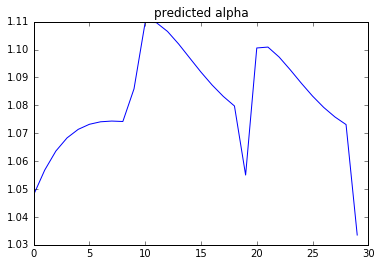

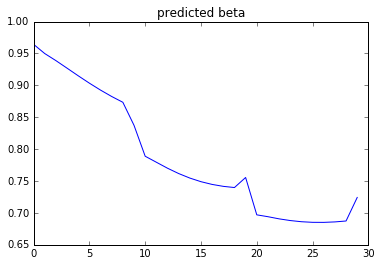

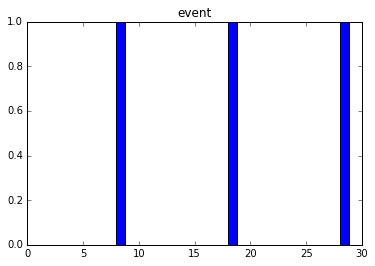

In [6]:
# results: It's learning something!!
batch_indx = 0
a = test_predict[batch_indx,:,0]
b = test_predict[batch_indx,:,1]
plt.plot(a)
plt.title('predicted alpha')
plt.show()
plt.plot(b)
plt.title('predicted beta')
plt.show()

plt.bar(xrange(seq_len),events.T[batch_indx,:])
plt.title('event')
plt.show()

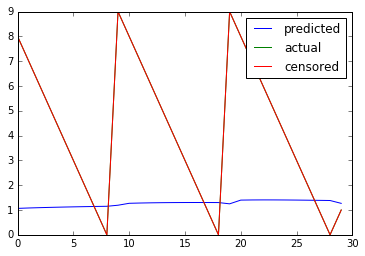

In [7]:
# But it's horribly out of scale. More work needed :) 
def weibull_mean(a, b):
    # Continuous mean. theoretically at most 1 step below discretized mean 
    # E[T ] ≤ E[Td] + 1 true for positive distributions. 
    # Might be numerically unstable
    from scipy.special import gamma
    return a*gamma(1.0+1.0/b)

plt.plot(weibull_mean(a,b),label='predicted')
plt.plot(test_y[batch_indx,:,0] ,label='actual')
plt.plot(train_y[batch_indx,:,0],label='censored')
plt.legend()